# Text Recognition Model: Training and Tuning

> NOTE: This sample notebook has been executed in a laptop without a GPU, hence the bad results.

In [ ]:
# pip install googledrivedownloader

In [1]:
from tfgpkg.recognition import DataUnpack, DataGen
from tfgpkg.recognition.word import StringVectorizer, RecognitionNet, Arch
from tfgpkg.recognition.datagen import DataGen
from tensorflow import keras

from google_drive_downloader import GoogleDriveDownloader as gdd
from shutil import make_archive, rmtree as rm_dir
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import h5py as h5
import cv2
import os

In [2]:
tf.__version__

'2.3.1'

In [3]:
visible_devices = tf.config.experimental.get_visible_devices()

print(visible_devices, "\n")

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 



In [ ]:
# help(tf.config.experimental.set_visible_devices)

In [4]:
tf.config.experimental.set_visible_devices(visible_devices[0])  # it drops some physical devices from the logical devices

In [5]:
print(tf.config.list_logical_devices())

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU')]


### Data Download (just once)

In [6]:
dataset_dest_dir = "datasets"
os.makedirs(dataset_dest_dir, exist_ok=True)

In [ ]:
drive_ids = {
    "spanish": "1Xt_Mq-Alg0yptfKgoxXoD-O0-Iyj5-2s",
    "iam": "11pUW60azvr722I7LaKS9s2pzwm_Con6V",
    "rimes": "1wb4CEHOV0JSIt2VaqXhGUeHfV5wzbHlg"
}
url_format = "https://drive.google.com/uc?id={}"

# gdd.download_file_from_google_drive(drive_ids["spanish"], dest_path=f"./{dataset_dest_dir}/spanish.h5")
# gdd.download_file_from_google_drive(drive_ids["iam"], dest_path=f"./{dataset_dest_dir}/iam.h5")
# gdd.download_file_from_google_drive(drive_ids["rimes"], dest_path=f"./{dataset_dest_dir}/rimes.h5")

In [7]:
MAX_WORD_LENGTH = 34  # 24

width, height = TARGET_SIZE = {
    "vsmall": (64, 16), # .25
    "small": (128, 32), # .50
    "medium": (192, 48), # .75
    "original": (256, 64)
}["medium"]

IMAGE_RATIO = width / height
print(IMAGE_RATIO)

4.0


### Data and Model Loading

In [5]:
%%time

unzip_dataset_dest_dir = TemporaryDirectory(prefix="htr_").name
save_to_disk = False

# train_spa, test_spa, valid_spa 
# train_rimes, test_rimes, valid_rimes
# train_iam, test_iam, valid_iam

# train_set, test_set, valid_set

train_set, test_set, valid_set = DataUnpack.unpack(
    f"{dataset_dest_dir}/spanish.h5",
    dest_dir=unzip_dataset_dest_dir,
    color=False,
    save_to_disk=save_to_disk,  # if the dataset is quite big or not enough ram
    target_size=TARGET_SIZE,
    aspect_ratio=IMAGE_RATIO
)

if save_to_disk:
    print(f"Unpacking dataset to {unzip_dataset_dest_dir}")

CPU times: user 380 ms, sys: 8.05 ms, total: 388 ms
Wall time: 390 ms


In [6]:
print(train_set[0].shape, train_set[1].shape)

(396, 192, 48, 1) (396,)


#### Create a new model...

In [10]:
train_logdir = "training_logs"
os.makedirs(train_logdir, exist_ok=True)

net = RecognitionNet(
    logdir=train_logdir,
    input_size=(*TARGET_SIZE, 1),
    arch=Arch.Depthwise
    # charset=RecognitionNet.LATIN_CHAR
)

In [ ]:
# gated, 75% input size
# net.model.summary()

In [ ]:
# gated, original input size
# net.model.summary()

In [ ]:
# depthwise, original input size
# net.model.summary()

In [6]:
# octave, 75% input size
# net.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 192, 48, 1)] 0                                            
__________________________________________________________________________________________________
octave_conv2d (OctaveConv2D)    [(None, 96, 24, 14), 160         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 48, 12, 2)    8           octave_conv2d[0][1]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 24, 14)   56          octave_conv2d[0][0]              
______________________________________________________________________________________________

In [12]:
# baseline, 75% input size
# net.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 192, 48, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 24, 16)        160       
_________________________________________________________________
p_re_lu (PReLU)              (None, 96, 24, 16)        16        
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 24, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 24, 32)        4640      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 96, 24, 32)        32        
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 24, 32)        128   

#### or import a trained one!

In [8]:
train_logdir = "training_logs"
trained_model_dir = "trained_models"
trained_model_name = "_".join(["octave", "iam", "55e", "spanish", "size75"])

In [11]:
os.makedirs(train_logdir, exist_ok=True)

net = RecognitionNet.load_model(f"./{trained_model_dir}/{trained_model_name}", (*TARGET_SIZE, 1))

### Data Augmentation

In [26]:
BATCH_SIZE = 64

train_opts = dict(width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, shear_range=0.2)

train_gen, test_gen, valid_gen = DataGen(train_set, test_set, valid_set, train_opts).from_tuple(BATCH_SIZE)

In [8]:
import gc

_ = gc.collect()

### Train the model

In [14]:
train_gen.reset()
valid_gen.reset()

---

#### Freeze the CNN and RNN layers (only if fine-tuning)

In [18]:
for layer in net.model.layers[:-2]:
    layer.trainable = False
    
print([[layer.trainable, layer.name] for layer in net.model.layers[-4:]])

[[False, 'dense_2'], [False, 'bidirectional_3'], [True, 'dense_3'], [True, 'activation_1']]


---

In [41]:
TRAIN_STEPS = (train_gen.n * 1) // BATCH_SIZE
VALID_STEPS = (valid_gen.n * 5) // BATCH_SIZE

print("Train steps: ", TRAIN_STEPS)
print("Validation steps: ", VALID_STEPS)

Train steps:  6
Validation steps:  3


In [45]:
%%time

EPOCHS = 40

training_results = net.model.fit(
    train_gen,
    steps_per_epoch=TRAIN_STEPS,
    validation_data=valid_gen,
    validation_steps=VALID_STEPS,
    epochs=EPOCHS,
    callbacks=net.callbacks,
    verbose=1
)

Epoch 1/40
6/6 [==============================] - 1s 87ms/step - loss: 2.3078 - val_loss: 7.8931 - lr: 0.0010
Epoch 2/40
6/6 [==============================] - 1s 87ms/step - loss: 2.2007 - val_loss: 12.2402 - lr: 0.0010
Epoch 3/40
6/6 [==============================] - 0s 79ms/step - loss: 2.0498 - val_loss: 14.3918 - lr: 0.0010
Epoch 4/40
6/6 [==============================] - 0s 81ms/step - loss: 2.0063 - val_loss: 11.4681 - lr: 0.0010
Epoch 5/40
6/6 [==============================] - 0s 81ms/step - loss: 2.1874 - val_loss: 12.6883 - lr: 0.0010
Epoch 6/40
6/6 [==============================] - 0s 82ms/step - loss: 1.9503 - val_loss: 12.6023 - lr: 0.0010
CPU times: user 6.02 s, sys: 294 ms, total: 6.31 s
Wall time: 3.5 s


---

#### Unfreeze the CNN and RNN layers (only if fine-tuning)

In [14]:
print([[layer.trainable, layer.name] for layer in net.model.layers[-4:]])

[[True, 'dense_2'], [True, 'bidirectional_3'], [True, 'dense_3'], [True, 'activation_1']]


In [18]:
for layer in net.model.layers:
    layer.trainable = True
    
print([[layer.trainable, layer.name] for layer in net.model.layers[-4:]])

[[False, 'dense_2'], [False, 'bidirectional_3'], [True, 'dense_3'], [True, 'activation_1']]


---

#### Check the statistics

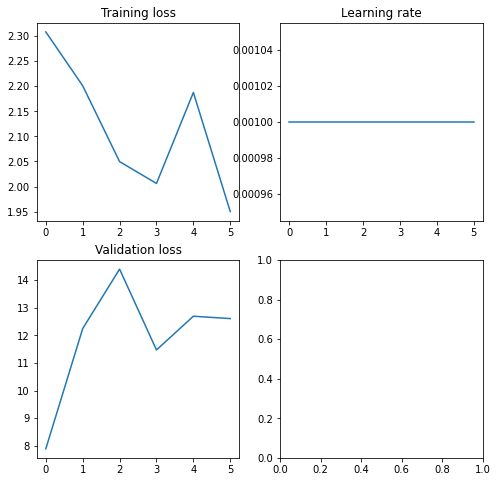

In [46]:
_, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.flatten()

axes[0].plot(training_results.history["loss"])
axes[0].set_title("Training loss")

axes[1].plot(training_results.history["lr"])
axes[1].set_title("Learning rate")

axes[2].plot(training_results.history["val_loss"])
axes[2].set_title("Validation loss")

plt.show()

#### Compute the WER and CER

In [29]:
test_gen.reset()

predictions, _ = net.predict(
    test_gen,
    steps=test_gen.n // BATCH_SIZE,
    # batch_size=BATCH_SIZE,
    verbose=1
)

print(f"\n{len(predictions)}")

# predictions = np.array(predictions)

Model Predict
1/1 [==============================] - 0s 2ms/step
CTC Decode


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


1/1 [==============================] - 0s 456ms/step

64


In [30]:
predictions2 = np.array([np.array(v[0]).flatten() for v in predictions])
predictions2[:3]

array([array([ 45,  72,  62, 100,  72]), array([45, 73, 72, 71]),
       array([72])], dtype=object)

In [31]:
vectorizer = StringVectorizer()

true_labels = [vectorizer.decode(encoded_vector) for encoded_vector in test_gen.y]
pred_labels = [vectorizer.decode(encoded_vector) for encoded_vector in predictions2]

In [32]:
RecognitionNet.compute_cer(true_labels, pred_labels) # the closer to 1.0, the worse

0.990990990990991

In [33]:
wer_results = [RecognitionNet.compute_wer(t, p) for t, p in zip(true_labels, pred_labels)]

print(np.mean(wer_results))
# the closer to 0.0, the better

6.921875


In [34]:
import gc

# del train_set, valid_set, train_gen, valid_gen

_ = gc.collect()

#### Evaluate the test dataset

In [35]:
test_gen.reset()

net.model.evaluate(
    test_gen,
    steps=test_gen.n // BATCH_SIZE,
    batch_size=BATCH_SIZE,
    verbose=1
)

1/1 [==============================] - 0s 1ms/step - loss: 13.5585


13.55845832824707

#### Test a network prediction

In [47]:
test_gen.reset()
test_batch = test_gen.next()

(64, 192, 48, 1) (64, 34)
distintos


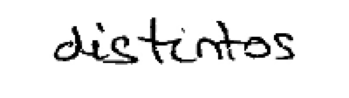

In [73]:
from keras.preprocessing.image import load_img, img_to_array

vectorizer = StringVectorizer()

print(test_batch[0].shape, test_batch[1].shape)

sample_idx = np.random.randint(BATCH_SIZE)

test_vector = test_batch[1][sample_idx, :]
print(vectorizer.decode(test_vector))

test_image = test_batch[0][sample_idx,:,:,0]
plt.imshow(test_image.transpose(), cmap="gray")
plt.axis("off")
plt.show()

In [74]:
test_image_pred = np.expand_dims(test_image, axis=[0,-1])

%time preds, probs = net.predict(test_image_pred)

CPU times: user 37.5 ms, sys: 3.45 ms, total: 40.9 ms
Wall time: 36.2 ms


In [75]:
vector = list(preds[0][0])

predicted_text = vectorizer.decode(vector)

print(predicted_text)

distintos


### (Optional) Post-training quantization

**IMPORTANT** Save the model first (see below!)

In [9]:
# !export PATH=$PATH:/home/pachacho/miniconda3/envs/deep/bin/toco_from_protos

def quantize_model(from_keras=None, from_saved_model=None, try_shrinking=False):
    if from_keras is not None:
        converter: tf.lite.TFLiteConverter = tf.lite.TFLiteConverter.from_keras_model(from_keras)
    elif from_saved_model is not None:
        converter: tf.lite.TFLiteConverter = tf.lite.TFLiteConverter.from_saved_model(from_saved_model)
    else:
        raise Exception("Parameters: ", from_keras, from_saved_model)
        
    converter.allow_custom_ops = True
    converter.experimental_new_converter = True
    converter.experimental_new_quantizer = True
    converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
    
    if try_shrinking:
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    else:
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
        
    converter.target_spec.supported_ops += [tf.lite.OpsSet.SELECT_TF_OPS]
    converter.target_spec.supported_types = [tf.float16] #  [tf.uint8]
    
    return converter.convert()


In [12]:
quant8_model = quantize_model(from_keras=net.model, try_shrinking=False)
# quant8_model = quantize_model(from_saved_model=f"./{trained_model_dir}/{trained_model_name}", try_shrinking=False)

type(quant8_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmplhr3l5e8/assets


bytes

In [13]:
trained_model_dir = "trained_models"
trained_model_name = "_".join(["octave", "iam", "55e", "spanish", "size75", "8bits", "experimental_converter"])

with open(f"./{trained_model_dir}/{trained_model_name}.tflite", "wb") as f:
    f.write(quant8_model)

---

#### Prediction with the quantized model

In [22]:
trained_model_name = "_".join(["octave", "iam", "55e", "spanish", "size75", "8bits"])

In [27]:
# Load TFLite model and allocate tensors.

# from binary model
with open(f"./{trained_model_dir}/{trained_model_name}.tflite", "rb") as f:
    bin_model = f.read()
    interpreter = tf.lite.Interpreter(model_content=bin_model)


In [ ]:
# from file
interpreter = tf.lite.Interpreter(model_path=f"./{trained_model_dir}/{trained_model_name}.tflite")

In [37]:
tensor_index = interpreter.get_input_details()[0]['index']
input_tensor_z = tf.convert_to_tensor(z, np.float32)
interpreter.set_tensor(tensor_index, input_tensor_z)

NameError: name 'z' is not defined

In [35]:
interpreter.allocate_tensors()

RuntimeError: Encountered unresolved custom op: TensorListFromTensor.Node number 34 (TensorListFromTensor) failed to prepare.
Encountered unresolved custom op: TensorListFromTensor.Node number 34 (TensorListFromTensor) failed to prepare.


In [34]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details, "\n\n", output_details)

[{'name': 'input', 'index': 17, 'shape': array([  1, 192,  48,   1], dtype=int32), 'shape_signature': array([  1, 192,  48,   1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}] 

 [{'name': 'Identity', 'index': 16, 'shape': array([], dtype=int32), 'shape_signature': array([], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

---

### Save the trained model to `protobuf` (portable) format

In [60]:
trained_model_dir = "trained_models"
trained_model_name = "_".join(["octave", "iam", "55e", "spanish", "size75"])

os.makedirs(trained_model_dir, exist_ok=True)

net.model.save(f"./{trained_model_dir}/{trained_model_name}")
make_archive(
    f"./{trained_model_dir}/{trained_model_name}",
    "zip",
    f"./{trained_model_dir}/{trained_model_name}/"
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./trained_models/octave_iam_55e_spanish_size75/assets


'/home/pachacho/Documents/text-processing/playground/trained_models/octave_iam_55e_spanish_size75.zip'

#### End

In [ ]:
# remove the temporal directory in the end
if save_to_disk:
    rm_dir(dataset_dest_dir)